In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/private/dim_ad_category.xlsx
/kaggle/input/private/fact_digital_pilot.csv
/kaggle/input/private/fact_print_sales.xlsx
/kaggle/input/private/fact_ad_revenue.csv
/kaggle/input/private/fact_city_readiness.csv
/kaggle/input/private/dim_city.xlsx


# 0. Import Libraries 

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Load All Datasets

In [3]:
df_ad_category = pd.read_excel('/kaggle/input/private/dim_ad_category.xlsx')
df_ad_category.to_csv('dim_ad_category.csv', index=False)
df_ad_rev = pd.read_csv('/kaggle/input/private/fact_ad_revenue.csv')
df_city_readiness = pd.read_csv('/kaggle/input/private/fact_ad_revenue.csv')
df_digital_pilot = pd.read_csv('/kaggle/input/private/fact_digital_pilot.csv')
df_print_sales = pd.read_excel('/kaggle/input/private/fact_print_sales.xlsx')
df_print_sales.to_csv('df_print_sales.csv', index=False)
df_city = pd.read_excel('/kaggle/input/private/dim_city.xlsx')
df_city.to_csv('df_city.csv', index=False)

# 2. Meticulous Data Cleaning & Preparation

In [4]:
# --- 2.1. Universal Cleaning Function for Quarters ---
def standardize_quarter(q_str):
    """Standardize quarter strings into YYYY-Q# format."""
    if not isinstance(q_str, str):
        return None
    q_str = q_str.strip()
    year_match = re.search(r'\d{4}', q_str)
    if not year_match:
        return None
    year = year_match.group(0)
    quarter_match = re.search(r'Q\s*(\d)|(\d)\s*(?:st|nd|rd|th)', q_str, re.IGNORECASE)
    if not quarter_match:
        return None
    quarter = quarter_match.group(1) or quarter_match.group(2)
    return f"{year}-Q{quarter}"

In [5]:
def clean_and_rename(df, rename_map=None):
    """Standardize column names and rename known variations."""
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    if rename_map:
        df.rename(columns=rename_map, inplace=True)
    return df


In [6]:
# --- 2.2. Clean Dimension Tables: `dim_city` and `dim_ad_category` ---
if not df_city.empty:
    df_city = clean_and_rename(df_city, rename_map={'city_id': 'city_id'})
    if 'city' in df_city.columns:
        df_city['city'] = df_city['city'].str.title()
    if 'state' in df_city.columns:
        df_city['state'] = df_city['state'].str.title()

if not df_ad_category.empty:
    df_ad_category = clean_and_rename(df_ad_category)

In [7]:
# --- 2.3. Clean Fact Table: `fact_print_sales` ---
if not df_print_sales.empty:
    rename_map = {
        'copies_sold': 'copies_sold',
        'copies_returned': 'copies_returned',
        'copies printed': 'copies_printed',
    }
    df_print_sales = clean_and_rename(df_print_sales, rename_map=rename_map)

    # Convert numeric fields
    for col in ['copies_sold', 'copies_returned', 'net_circulation']:
        if col in df_print_sales.columns:
            df_print_sales[col] = pd.to_numeric(
                df_print_sales[col].astype(str).str.replace(r'[^\d.]', '', regex=True),
                errors='coerce'
            )

    # Compute copies_printed if missing
    if 'copies_printed' not in df_print_sales.columns:
        if all(c in df_print_sales.columns for c in ['copies_sold', 'copies_returned']):
            df_print_sales['copies_printed'] = (
                df_print_sales['copies_sold'] + df_print_sales['copies_returned']
            )

    # Parse month and drop missing essential rows
    if 'month' in df_print_sales.columns:
        df_print_sales['month'] = pd.to_datetime(df_print_sales['month'], errors='coerce')
    required = [c for c in ['month', 'net_circulation', 'city_id', 'copies_printed'] if c in df_print_sales.columns]
    df_print_sales.dropna(subset=required, inplace=True)

    print("Cleaned 'fact_print_sales'.")

Cleaned 'fact_print_sales'.


In [8]:
# --- 2.4. Clean Fact Table: `fact_ad_revenue` ---
if not df_ad_rev.empty:
    df_ad_rev = clean_and_rename(df_ad_rev)

    if 'quarter' in df_ad_rev.columns:
        df_ad_rev['quarter_std'] = df_ad_rev['quarter'].apply(standardize_quarter)

    if 'currency' in df_ad_rev.columns:
        df_ad_rev['currency'] = df_ad_rev['currency'].str.strip().replace('IN RUPEES', 'INR')

    # Currency conversion
    exchange_rates = {'USD': 80, 'EUR': 90, 'INR': 1}
    if 'ad_revenue' in df_ad_rev.columns:
        df_ad_rev['ad_revenue_inr'] = df_ad_rev.apply(
            lambda row: row['ad_revenue'] * exchange_rates.get(row.get('currency'), 1),
            axis=1
        )

    # Create city_id from edition_id
    if 'edition_id' in df_ad_rev.columns:
        df_ad_rev['city_id'] = 'C' + df_ad_rev['edition_id'].str[4:].str.zfill(3)

    # Extract year
    if 'quarter_std' in df_ad_rev.columns:
        df_ad_rev.dropna(subset=['quarter_std'], inplace=True)
        df_ad_rev['year'] = pd.to_numeric(df_ad_rev['quarter_std'].str[:4], errors='coerce')
        df_ad_rev.dropna(subset=['year'], inplace=True)
        df_ad_rev['year'] = df_ad_rev['year'].astype(int)

    print("Cleaned 'fact_ad_revenue'.")

Cleaned 'fact_ad_revenue'.


In [9]:
# --- Clean Fact Table: fact_city_readiness ---
if not df_city_readiness.empty:
    # Drop ghost index columns
    ghost_cols = [c for c in df_city_readiness.columns if c.lower().startswith("unnamed")]
    df_city_readiness.drop(columns=ghost_cols, inplace=True, errors='ignore')

    # Standardize column names (lowercase, underscores)
    df_city_readiness.columns = (
        df_city_readiness.columns.str.strip().str.lower().str.replace(" ", "_")
    )

    # Standardize quarter format
    if "quarter" in df_city_readiness.columns:
        df_city_readiness["quarter"] = df_city_readiness["quarter"].apply(standardize_quarter)

    # Drop rows with missing essential fields (only if columns exist)
    required_cols = ["quarter", "city_id", "internet_penetration"]
    existing_cols = [c for c in required_cols if c in df_city_readiness.columns]
    if existing_cols:
        df_city_readiness.dropna(subset=existing_cols, inplace=True)
    else:
        print(f"⚠️ Columns missing entirely: {set(required_cols) - set(df_city_readiness.columns)}")

    print("✅ Cleaned fact_city_readiness")


✅ Cleaned fact_city_readiness


In [10]:
# --- 2.6. Clean Fact Table: `fact_digital_pilot` ---
if not df_digital_pilot.empty:
    df_digital_pilot = clean_and_rename(df_digital_pilot)
    for col in df_digital_pilot.columns:
        if col.startswith('unnamed'):
            df_digital_pilot.drop(columns=[col], inplace=True)
    print("Cleaned 'fact_digital_pilot'.")

Cleaned 'fact_digital_pilot'.


# 3. Answering Business Requests

In [11]:
# --- Helper to safely check columns ---
def has_columns(df, cols):
    """Check if all required columns exist in a DataFrame."""
    return all(c in df.columns for c in cols)

In [12]:
# --- Request 1: Top 3 Monthly Circulation Drops ---
if not df_print_sales.empty and has_columns(df_print_sales, ['city_id', 'month', 'net_circulation']):
    print("\n--- Request 1: Top 3 Monthly Circulation Drops ---")
    df_ps = df_print_sales.sort_values(by=['city_id', 'month']).copy()
    df_ps['prev_month_circulation'] = df_ps.groupby('city_id')['net_circulation'].shift(1)
    df_ps.dropna(subset=['prev_month_circulation'], inplace=True)
    df_ps['mom_decline_abs'] = df_ps['prev_month_circulation'] - df_ps['net_circulation']
    top_3 = pd.merge(df_ps.nlargest(3, 'mom_decline_abs'), df_city, on='city_id', how='left')
    print(top_3[['city', 'month', 'net_circulation', 'prev_month_circulation', 'mom_decline_abs']].round(0))
else:
    print("\n--- Request 1 --- Skipped: Missing required data.")


--- Request 1: Top 3 Monthly Circulation Drops ---
       city      month  net_circulation  prev_month_circulation  \
0  Varanasi 2021-01-01           382018                441825.0   
1  Varanasi 2019-11-01           431606                487255.0   
2    Jaipur 2020-01-01           420680                472538.0   

   mom_decline_abs  
0          59807.0  
1          55649.0  
2          51858.0  


In [13]:
# --- Request 2: Top Contributing Ad Category Per Year ---
if not df_ad_rev.empty and not df_ad_category.empty and has_columns(df_ad_rev, ['year', 'ad_category', 'ad_revenue_inr']):
    print("\n--- Request 2: Top Ad Category Contribution by Year ---")
    yearly_cat_rev = df_ad_rev.groupby(['year', 'ad_category'])['ad_revenue_inr'].sum().reset_index()
    yearly_total = df_ad_rev.groupby('year')['ad_revenue_inr'].sum().reset_index().rename(columns={'ad_revenue_inr': 'total_revenue_year'})
    merged = pd.merge(yearly_cat_rev, yearly_total, on='year')
    merged['pct_of_year_total'] = (merged['ad_revenue_inr'] / merged['total_revenue_year']) * 100
    top_categories = merged.loc[merged.groupby('year')['pct_of_year_total'].idxmax()]
    result = pd.merge(top_categories, df_ad_category, left_on='ad_category', right_on='ad_category_id', how='left')
    print(result[['year', 'standard_ad_category', 'ad_revenue_inr', 'total_revenue_year', 'pct_of_year_total']].round(2))
else:
    print("\n--- Request 2 --- Skipped: Missing required data.")



--- Request 2: Top Ad Category Contribution by Year ---
   year standard_ad_category  ad_revenue_inr  total_revenue_year  \
0  2019           Government     127089460.7         357236073.9   
1  2020           Government     105056596.2         346551555.9   
2  2021          Real Estate     124790289.2         359518848.1   
3  2022          Real Estate     108666383.1         354082607.3   
4  2023          Real Estate     114005932.7         367429963.2   
5  2024          Real Estate     111565385.5         364501137.1   

   pct_of_year_total  
0              35.58  
1              30.31  
2              34.71  
3              30.69  
4              31.03  
5              30.61  


In [14]:
# --- Request 3: 2024 Print Efficiency Leaderboard ---
if not df_print_sales.empty and has_columns(df_print_sales, ['month', 'copies_printed', 'net_circulation', 'city_id']):
    print("\n--- Request 3: 2024 Print Efficiency Leaderboard ---")
    df_2024 = df_print_sales[df_print_sales['month'].dt.year == 2024].copy()
    if not df_2024.empty:
        summary_2024 = df_2024.groupby('city_id').agg(
            printed=('copies_printed', 'sum'),
            circulated=('net_circulation', 'sum')
        ).reset_index()
        summary_2024['efficiency'] = summary_2024['circulated'] / summary_2024['printed']
        summary_2024['rank'] = summary_2024['efficiency'].rank(method='dense', ascending=False).astype(int)
        top_5 = pd.merge(summary_2024.sort_values('rank').head(5), df_city, on='city_id', how='left')
        print(top_5[['city', 'printed', 'circulated', 'efficiency', 'rank']].round(2))
    else:
        print("⚠️ No print sales data found for 2024.")
else:
    print("\n--- Request 3 --- Skipped: Missing required data.")


--- Request 3: 2024 Print Efficiency Leaderboard ---
        city  printed  circulated  efficiency  rank
0     Ranchi  2309444     2092062        0.91     1
1  Ahmedabad  3046823     2746691        0.90     2
2      Patna  2506557     2252819        0.90     3
3     Jaipur  4594153     4128641        0.90     4
4   Varanasi  4591555     4123611        0.90     5


In [15]:
# Drop ghost index column
df_city_readiness.drop(
    columns=[c for c in df_city_readiness.columns if c.lower().startswith("unnamed")],
    inplace=True,
    errors='ignore'
)

# Standardize column names
df_city_readiness.columns = (
    df_city_readiness.columns.str.strip().str.lower().str.replace(" ", "_")
)

# Standardize quarters
import re
def standardize_quarter(q_str):
    if not isinstance(q_str, str): return None
    q_str = q_str.strip()
    year_match = re.search(r'\d{4}', q_str)
    if not year_match: return None
    year = year_match.group(0)
    quarter_match = re.search(r'Q\s*(\d)|(\d)\s*(?:st|nd|rd|th)', q_str, re.IGNORECASE)
    if not quarter_match: return None
    quarter = quarter_match.group(1) or quarter_match.group(2)
    return f"{year}-Q{quarter}"

if "quarter" in df_city_readiness.columns:
    df_city_readiness["quarter"] = df_city_readiness["quarter"].apply(standardize_quarter)

# Drop rows with missing essentials
required_cols = ["quarter", "city_id", "internet_penetration"]
if all(col in df_city_readiness.columns for col in required_cols):
    df_city_readiness.dropna(subset=required_cols, inplace=True)
else:
    print(f"⚠️ Columns missing: {set(required_cols) - set(df_city_readiness.columns)}")

# Show the first few rows
print(df_city_readiness.head())

⚠️ Columns missing: {'city_id', 'internet_penetration'}
  edition_id ad_category  quarter  ad_revenue currency comments
0     ED1005        A001  2023-Q2    22613.69      EUR      NaN
1     ED1005        A002  2019-Q1    39366.88      USD      NaN
2     ED1001        A003  2023-Q3  3709860.00      INR      NaN
3     ED1003        A002  2023-Q3    40969.55      USD      NaN
4     ED1007        A003  2020-Q4    51779.40      USD      NaN


In [16]:
# Load ONLY fact_city_readiness
df_city_readiness = pd.read_csv("/kaggle/input/private/fact_city_readiness.csv")

# Show the actual column names
print("City Readiness Columns:", df_city_readiness.columns.tolist())

# Show a few rows
print(df_city_readiness.head())


City Readiness Columns: ['Unnamed: 0', 'city_id', 'quarter', 'literacy_rate', 'smartphone_penetration', 'internet_penetration']
   Unnamed: 0 city_id  quarter  literacy_rate  smartphone_penetration  \
0           0    C001  2019-Q1          89.16                   75.76   
1           1    C001  2019-Q2          88.76                   76.45   
2           2    C001  2019-Q3          88.83                   75.32   
3           3    C001  2019-Q4          89.25                   75.83   
4           4    C001  2020-Q1          89.13                   75.03   

   internet_penetration  
0                 56.53  
1                 55.97  
2                 56.52  
3                 56.94  
4                 56.45  


In [17]:
# --- Request 4: Internet Readiness Growth in 2021 ---
if not df_city_readiness.empty:
    required_cols = {"city_id", "quarter", "internet_penetration"}
    missing = required_cols - set(df_city_readiness.columns)

    if missing:
        print(f"\n--- Request 4 --- Skipped: Missing columns {missing}")
    else:
        print("\n--- Request 4: Internet Readiness Growth in 2021 ---")
        # Filter data for 2021 Q1 and Q4
        readiness_2021 = df_city_readiness[
            df_city_readiness["quarter"].isin(["2021-Q1", "2021-Q4"])
        ].copy()

        if not readiness_2021.empty:
            # Pivot for comparison
            pivoted = readiness_2021.pivot_table(
                index="city_id",
                columns="quarter",
                values="internet_penetration"
            ).reset_index()

            # Check both quarters exist
            if {"2021-Q1", "2021-Q4"}.issubset(pivoted.columns):
                pivoted.dropna(subset=["2021-Q1", "2021-Q4"], inplace=True)
                pivoted["delta"] = pivoted["2021-Q4"] - pivoted["2021-Q1"]

                # Find city with highest growth
                highest = pd.merge(
                    pivoted.nlargest(1, "delta"),
                    df_city,
                    on="city_id",
                    how="left"
                )

                print(highest[["city", "2021-Q1", "2021-Q4", "delta"]].round(2))
            else:
                print("⚠️ Data for both 2021-Q1 and 2021-Q4 not available for all cities.")
        else:
            print("⚠️ No readiness data found for 2021-Q1 or 2021-Q4.")
else:
    print("\n--- Request 4 --- Skipped: df_city_readiness is empty.")



--- Request 4: Internet Readiness Growth in 2021 ---
     city  2021-Q1  2021-Q4  delta
0  Kanpur    74.27    76.77    2.5


In [18]:
# --- Request 5: Cities with Consistent Decline ---
print("\n## Request 5: Cities with Consistent Decline\n")

if not df_print_sales.empty and not df_ad_rev.empty:
    required_sales = {"month", "city_id", "net_circulation"}
    required_rev = {"year", "city_id", "ad_revenue_inr"}

    if required_sales.issubset(df_print_sales.columns) and required_rev.issubset(df_ad_rev.columns):
        # Prepare yearly circulation data
        yearly_circ = (
            df_print_sales
            .groupby(["city_id", df_print_sales["month"].dt.year])["net_circulation"]
            .sum()
            .reset_index()
            .rename(columns={"month": "year"})
        )

        # Prepare yearly revenue data
        yearly_rev = (
            df_ad_rev
            .groupby(["city_id", "year"])["ad_revenue_inr"]
            .sum()
            .reset_index()
        )

        # Merge circulation & revenue
        summary = pd.merge(yearly_circ, yearly_rev, on=["city_id", "year"], how="inner")

        # Debug: show first few rows
        print("### Yearly Summary (First 10 rows):")
        print(summary.head(10))
        print()

        # Helper function for strict monotonic decline
        def is_declining(series):
            return series.is_monotonic_decreasing and not series.is_monotonic_increasing

        # Filter cities that meet decline criteria
        declining = summary.groupby("city_id").filter(
            lambda x: len(x) >= 3 and is_declining(x["net_circulation"]) and is_declining(x["ad_revenue_inr"])
        )

        if not declining.empty:
            result = pd.merge(declining[["city_id"]].drop_duplicates(), df_city, on="city_id", how="left")
            print("\n### Cities with Consistent Decline in Both Metrics:")
            print(result[["city"]])
        else:
            print("\n⚠️ No cities found with a strict, monotonic decline in both metrics over ≥3 years.")
            print("Try relaxing conditions or reviewing the yearly summary above.")
    else:
        print("\n⚠️ Missing required columns for Request 5.")
else:
    print("\n⚠️ One or more required datasets are empty.")



## Request 5: Cities with Consistent Decline

### Yearly Summary (First 10 rows):
  city_id  year  net_circulation  ad_revenue_inr
0    C001  2019          2336155      37253879.2
1    C001  2020          2234098      32820036.0
2    C001  2021          2115877      37523945.3
3    C001  2022          2003659      32546360.9
4    C001  2023          1880340      36986028.5
5    C001  2024          1763256      40290839.5
6    C002  2019          4354258      33233498.2
7    C002  2020          4157369      33953041.2
8    C002  2021          3904669      39092403.6
9    C002  2022          3706456      42596542.0


⚠️ No cities found with a strict, monotonic decline in both metrics over ≥3 years.
Try relaxing conditions or reviewing the yearly summary above.


In [19]:
# --- Request 6: 2021 Digital Outlier ---
if not df_city_readiness.empty and not df_digital_pilot.empty and has_columns(df_city_readiness, ['city_id', 'quarter', 'internet_penetration']) and has_columns(df_digital_pilot, ['city_id', 'downloads_or_accesses']):
    print("\n--- Request 6: 2021 Digital Outlier ---")
    readiness_2021 = df_city_readiness[df_city_readiness['quarter'].str.startswith('2021')].copy()
    if not readiness_2021.empty:
        readiness_scores = readiness_2021.groupby('city_id')['internet_penetration'].mean().reset_index()
        readiness_scores['readiness_rank'] = readiness_scores['internet_penetration'].rank(ascending=False).astype(int)

        pilot_engagement = df_digital_pilot.groupby('city_id')['downloads_or_accesses'].sum().reset_index()
        pilot_engagement['engagement_rank'] = pilot_engagement['downloads_or_accesses'].rank(ascending=True).astype(int)

        combined = pd.merge(readiness_scores, pilot_engagement, on='city_id', how='inner')
        outlier = combined[(combined['readiness_rank'] == 1) & (combined['engagement_rank'] <= 3)]

        if not outlier.empty:
            result = pd.merge(outlier, df_city, on='city_id', how='left')
            print("Outlier City Found:")
            print(result[['city', 'internet_penetration', 'readiness_rank', 'downloads_or_accesses', 'engagement_rank']].round(2))
        else:
            print("No outlier city found (Rank 1 readiness & Bottom 3 engagement).")
    else:
        print("⚠️ No readiness data for 2021.")
else:
    print("\n--- Request 6 --- Skipped: Missing required data.")


--- Request 6: 2021 Digital Outlier ---
Outlier City Found:
     city  internet_penetration  readiness_rank  downloads_or_accesses  \
0  Kanpur                 75.34               1                  36289   

   engagement_rank  
0                1  


# 4. Data Visualization

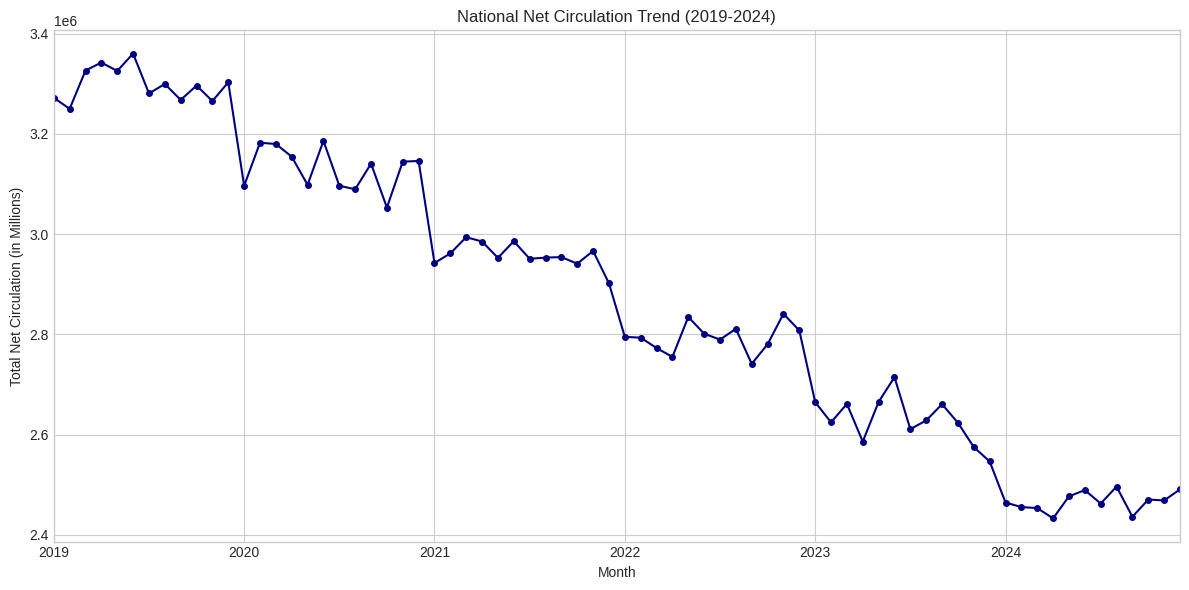

In [21]:
# Plot 1: National Print Circulation Trend
if not df_print_sales.empty:
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(12, 6))

    # Ensure month is datetime
    df_print_sales['month'] = pd.to_datetime(df_print_sales['month'], errors='coerce')

    # Group by month correctly
    monthly_circ = (
        df_print_sales
        .groupby(df_print_sales['month'].dt.to_period('M'))['net_circulation']
        .sum()
    )

    # Convert PeriodIndex back to datetime for plotting
    monthly_circ.index = monthly_circ.index.to_timestamp()

    # Plot
    monthly_circ.plot(
        kind='line',
        title='National Net Circulation Trend (2019-2024)',
        color='navy',
        marker='o',
        markersize=4
    )
    plt.xlabel("Month")
    plt.ylabel("Total Net Circulation (in Millions)")
    plt.tight_layout()
    plt.show()


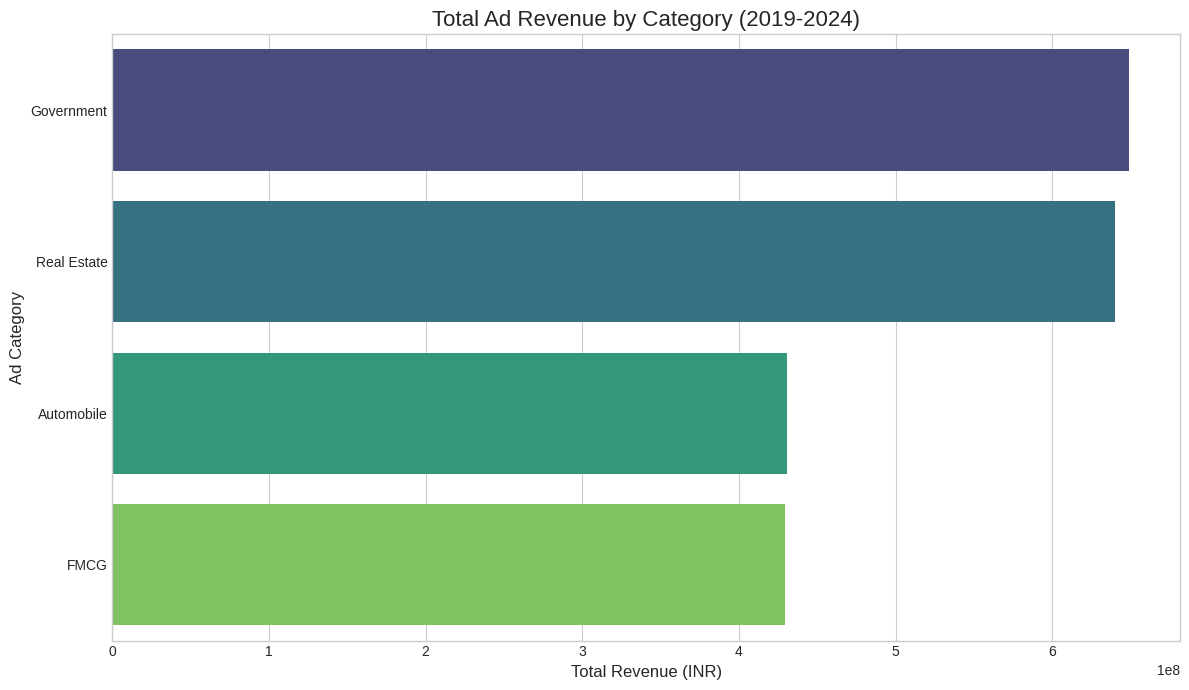

In [22]:

# Plot 2: Total Ad Revenue by Category
if not df_ad_rev.empty and not df_ad_category.empty:
    plt.figure(figsize=(12, 7))
    rev_by_cat = pd.merge(df_ad_rev, df_ad_category, left_on='ad_category', right_on='ad_category_id')
    total_rev_cat = rev_by_cat.groupby('standard_ad_category')['ad_revenue_inr'].sum().sort_values(ascending=False)
    sns.barplot(x=total_rev_cat.values, y=total_rev_cat.index, palette='viridis')
    plt.title('Total Ad Revenue by Category (2019-2024)', fontsize=16)
    plt.xlabel("Total Revenue (INR)", fontsize=12)
    plt.ylabel("Ad Category", fontsize=12)
    plt.tight_layout()
    plt.show()

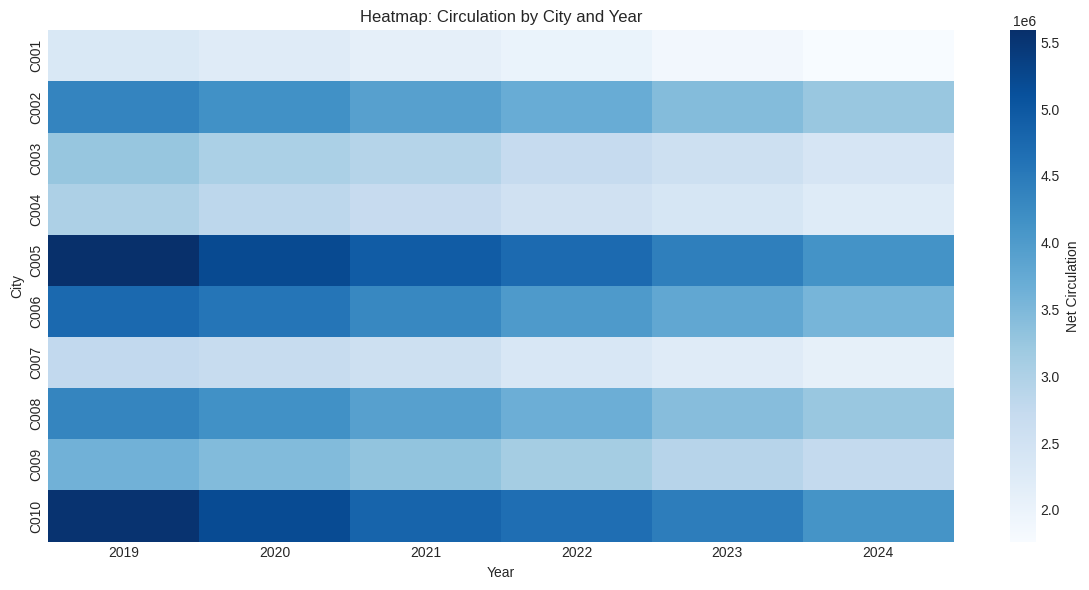

In [23]:
#Heatmap of Circulation by City and Year
if not df_print_sales.empty:
    df_print_sales['year'] = df_print_sales['month'].dt.year
    
    heatmap_data = (
        df_print_sales
        .groupby(['city_id', 'year'])['net_circulation']
        .sum()
        .reset_index()
    )
    pivot = heatmap_data.pivot(index='city_id', columns='year', values='net_circulation')

    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, cmap="Blues", annot=False, cbar_kws={'label': 'Net Circulation'})
    plt.title("Heatmap: Circulation by City and Year")
    plt.xlabel("Year")
    plt.ylabel("City")
    plt.tight_layout()
    plt.show()


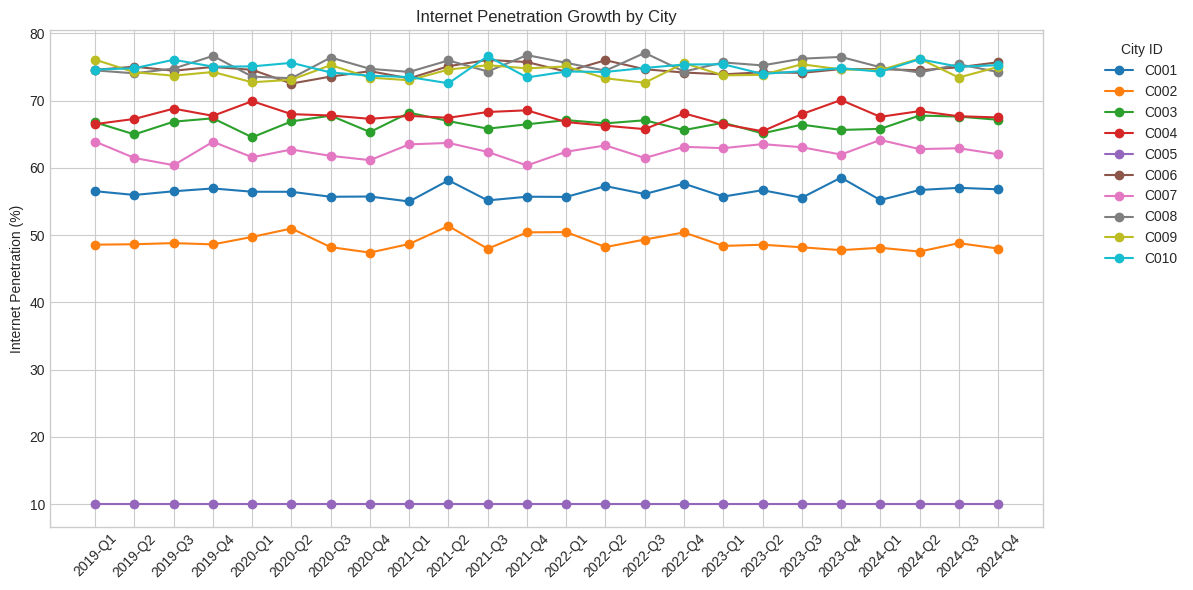

In [24]:
# Internet Penetration Growth by City (Line Plot)
if not df_city_readiness.empty:
    readiness_plot = (
        df_city_readiness
        .groupby(['quarter','city_id'])['internet_penetration']
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(12, 6))
    for city in readiness_plot['city_id'].unique():
        city_data = readiness_plot[readiness_plot['city_id'] == city]
        plt.plot(city_data['quarter'], city_data['internet_penetration'], marker='o', label=city)

    plt.title("Internet Penetration Growth by City")
    plt.xticks(rotation=45)
    plt.ylabel("Internet Penetration (%)")
    plt.legend(title="City ID", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


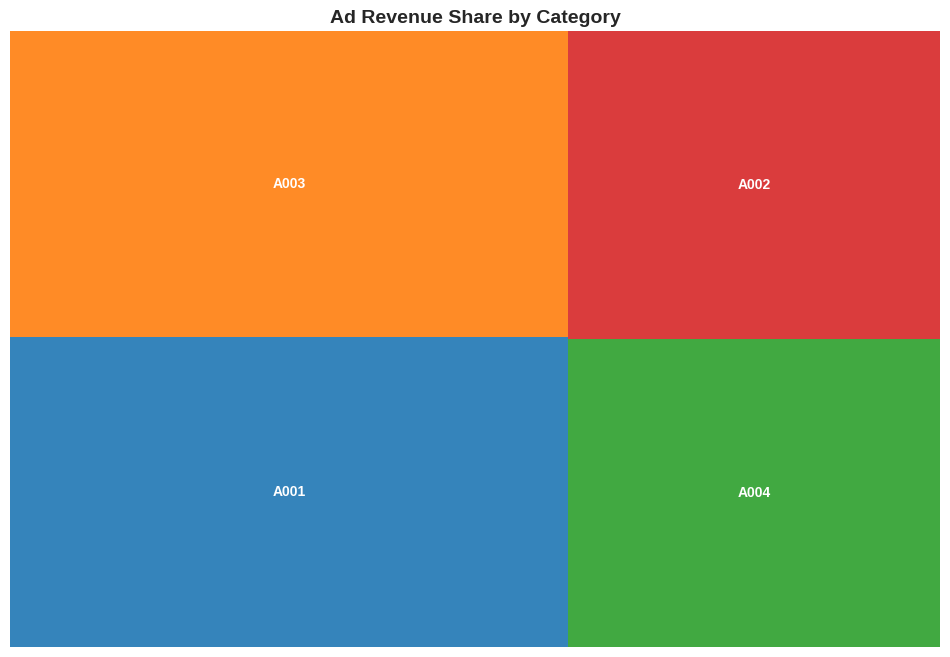

In [26]:
# Ad Revenue Share by Category (Treemap)
import squarify
import matplotlib.pyplot as plt

if not df_ad_rev.empty:
    category_share = (
        df_ad_rev.groupby('ad_category')['ad_revenue_inr']
        .sum()
        .reset_index()
        .sort_values('ad_revenue_inr', ascending=False)
    )

    # 🎨 Define custom HEX colors (adjust length to match categories)
    custom_colors = [
        "#1f77b4",  # blue
        "#ff7f0e",  # orange
        "#2ca02c",  # green
        "#d62728",  # red
        "#9467bd",  # purple
        "#8c564b",  # brown
        "#e377c2",  # pink
        "#7f7f7f",  # gray
        "#bcbd22",  # yellow-green
        "#17becf"   # teal
    ]

    plt.figure(figsize=(12, 8))
    squarify.plot(
        sizes=category_share['ad_revenue_inr'],
        label=category_share['ad_category'],
        color=custom_colors[:len(category_share)],  # match categories
        alpha=0.9,
        text_kwargs={'fontsize':10, 'color':'white', 'weight':'bold'}
    )
    plt.axis('off')
    plt.title("Ad Revenue Share by Category", fontsize=14, fontweight='bold')
    plt.show()


# 5. Applying Machine Learning Models


--- ML Model 1: Predicting Ad Revenue from Circulation ---
Model R-squared: 0.04 (This indicates the model's predictive power)
Impact of 1 Circulated Copy on Ad Revenue: -0.89 INR


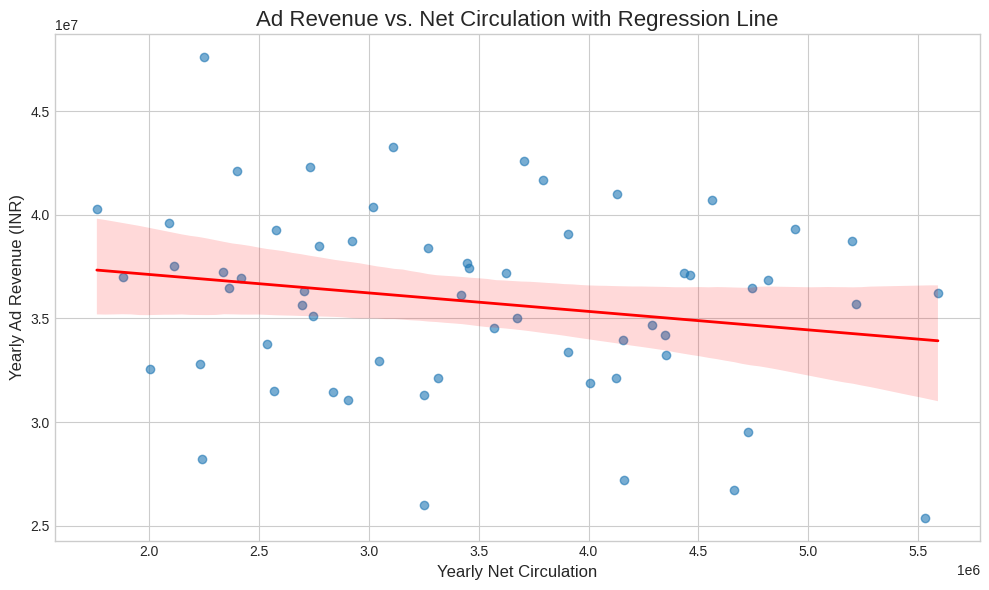

In [27]:
# --- Model 1: Linear Regression (Ad Revenue vs. Circulation) ---
if not df_print_sales.empty and not df_ad_rev.empty:
    print("\n--- ML Model 1: Predicting Ad Revenue from Circulation ---")
    yearly_circ = df_print_sales.groupby(['city_id', df_print_sales['month'].dt.year])['net_circulation'].sum().reset_index().rename(columns={'month': 'year'})
    yearly_rev = df_ad_rev.groupby(['city_id', 'year'])['ad_revenue_inr'].sum().reset_index()
    ml_df = pd.merge(yearly_circ, yearly_rev, on=['city_id', 'year'])
    
    if not ml_df.empty and ml_df.shape[0] > 1:
        X = ml_df[['net_circulation']]
        y = ml_df['ad_revenue_inr']
        model = LinearRegression()
        model.fit(X, y)
        print(f"Model R-squared: {model.score(X, y):.2f} (This indicates the model's predictive power)")
        print(f"Impact of 1 Circulated Copy on Ad Revenue: {model.coef_[0]:.2f} INR")

        plt.figure(figsize=(10, 6))
        sns.regplot(x='net_circulation', y='ad_revenue_inr', data=ml_df, line_kws={'color': 'red', 'linewidth': 2}, scatter_kws={'alpha': 0.6})
        plt.title('Ad Revenue vs. Net Circulation with Regression Line', fontsize=16)
        plt.xlabel('Yearly Net Circulation', fontsize=12)
        plt.ylabel('Yearly Ad Revenue (INR)', fontsize=12)
        plt.tight_layout()
        plt.show()


--- ML Model 2: Segmenting Cities by Digital Readiness ---
City Segments based on latest Digital Readiness:
        city    tier  internet_penetration segment
3      Patna  Tier 2                 67.50  Tier 1
6     Ranchi  Tier 3                 62.02  Tier 1
7     Kanpur  Tier 2                 74.26  Tier 1
8  Ahmedabad  Tier 1                 75.01  Tier 1
9   Varanasi  Tier 2                 75.28  Tier 1
1      Delhi  Tier 1                 48.00  Tier 2
5     Mumbai  Tier 1                 75.71  Tier 2
0    Lucknow  Tier 2                 56.81  Tier 3
2     Bhopal  Tier 2                 67.15  Tier 3
4     Jaipur  Tier 2                 10.00  Tier 3


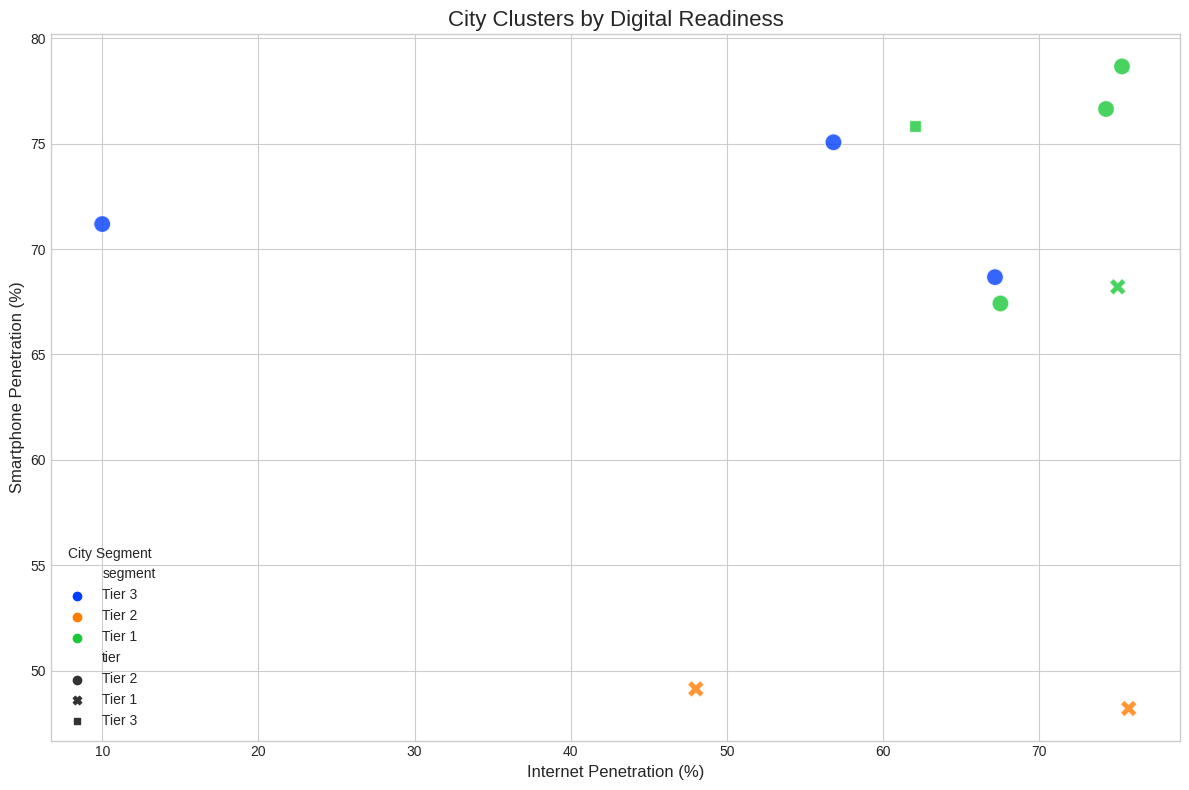

In [28]:
# --- Model 2: K-Means Clustering (City Segmentation) ---
if not df_city_readiness.empty:
    print("\n--- ML Model 2: Segmenting Cities by Digital Readiness ---")
    latest_quarters = df_city_readiness.groupby('city_id')['quarter'].max().reset_index()
    latest_readiness = pd.merge(df_city_readiness, latest_quarters, on=['city_id', 'quarter'])
    
    features = ['literacy_rate', 'smartphone_penetration', 'internet_penetration']
    X_cluster = latest_readiness[features].dropna()
    
    if not X_cluster.empty:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_cluster)
        
        kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
        latest_readiness.loc[X_cluster.index, 'cluster'] = kmeans.fit_predict(X_scaled)
        
        # Add meaningful labels to the clusters
        cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
        mean_internet = cluster_centers[:, 2] # internet_penetration is the 3rd feature
        cluster_map = {list(mean_internet).index(val): f"Tier {i+1}" for i, val in enumerate(sorted(mean_internet, reverse=True))}
        latest_readiness['segment'] = latest_readiness['cluster'].map(cluster_map)

        br_cluster = pd.merge(latest_readiness, df_city, on='city_id', how='left')
        print("City Segments based on latest Digital Readiness:")
        print(br_cluster[['city', 'tier', 'internet_penetration', 'segment']].sort_values('segment'))

        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=br_cluster, x='internet_penetration', y='smartphone_penetration', hue='segment', palette='bright', s=150, alpha=0.8, style='tier')
        plt.title('City Clusters by Digital Readiness', fontsize=16)
        plt.xlabel('Internet Penetration (%)', fontsize=12)
        plt.ylabel('Smartphone Penetration (%)', fontsize=12)
        plt.legend(title='City Segment')
        plt.tight_layout()
        plt.show()



###  Full ML Model Comparison 

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb
import pandas as pd
import numpy as np

# --- Prepare dataset ---
df = df_city_readiness.copy()

X = df[['literacy_rate', 'smartphone_penetration']]
y = df['internet_penetration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Define models ---
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=200, random_state=42, objective="reg:squarederror"),
    "LightGBM": lgb.LGBMRegressor(n_estimators=200, random_state=42),
    "SVR (RBF)": SVR(kernel='rbf', C=100, gamma=0.1),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5)
}

# --- Train & Evaluate ---
results = []
for name, model in models.items():
    pipe = Pipeline([("scaler", StandardScaler()), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results.append({"Model": name, "RMSE": rmse, "R²": r2})

results_df = pd.DataFrame(results).sort_values("R²", ascending=False)
print(results_df)


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127
[LightGBM] [Info] Number of data points in the train set: 192, number of used features: 2
[LightGBM] [Info] Start training from score 61.593750
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain